<a href="https://colab.research.google.com/github/MatheoCruz/BLR_imputation_perovskite/blob/main/Evaluacion_estimacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROYECTO DE GRADO: ETAPA DE EVALUACION (Imputación por estimación)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## IMPORTACION DE LIBRERIAS

In [ ]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from functools import partial
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from scipy import stats
import seaborn as sns
import pickle
import arviz as az

## FUNCIONES
- calculo_mape: Permite calcular la metrica de rendimiento mape
- parametros_rendimiento: Toma como variables de entrada las estimaciones y los valores de testeo para calcular el rendimeinto del modelo frente a distintas metricas, utilizando como valor frecuentista estimado la condicion de medicion.

In [ ]:
#--------------------------------FUNCIONES--------------------------------------
#Funcion para calcular el MAPE
def calculo_mape(y_true, y_pred):
  mask = (y_true != 0)
  y_true_masked = y_true[mask]
  y_pred_masked = y_pred[mask]
  absolute_errors = np.abs(y_true_masked - y_pred_masked)
  percentage_errors = absolute_errors / y_true_masked
  mape = np.mean(percentage_errors) * 100
  return mape
#-------------------------------------------------------------------------------
# Funcion para calcular parametros de rendimiento a partir de un parametro de medicion
def parametros_rendimiento(y_pred, y_true, medicion):
    # Calcular las métricas de rendimiento
    if medicion == "mean":
      y_pred = np.mean(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la media de la prediccion")
    elif medicion == "mode":
      y_pred = stats.mode(y_pred, axis = 1)[0]
      print("Parametros de rendimiento respecto a la moda de la prediccion")
    elif medicion == "median":
      y_pred = np.median(y_pred, axis = 1)
      print("Parametros de rendimiento respecto a la mediana de la prediccion")
    else:
      print("Opcion default, Parametros de rendimiento respecto la media de la prediccion")
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape_ = calculo_mape(y_true, y_pred)
    print("mse = ", mse)
    print("mae = ", mae)
    print("r2 = ", r2)
    print("mape = ", mape_)
    return mse, mae, r2, mape_
#-------------------------------------------------------------------------------

## CARGA DE ARCHIVOS

Se carga el archivo que contiene los trazos generados por la etapa de entrenamiento o inferencia bayesiana, ademas de datos de entrenamiento y testeo segmentados.

In [ ]:
#Descarga de los archivos que contienen los modelos inferidos y los datos asociados de entrenamiento y testeo
ruta_drive = '/content/drive/MyDrive/Deep Learning/TG/'
with open(ruta_drive + 'trazados_estimacion.pkl', 'rb') as f:
    trazados_cargados = pickle.load(f)
with open(ruta_drive + 'data_train_estimacion.pkl', 'rb') as f:
    data_train = pickle.load(f)
with open(ruta_drive + 'data_test_estimacion.pkl', 'rb') as f:
    data_test = pickle.load(f)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Deep Learning/TG/Preprocesamiento/datos_sintesis.csv")

## ESTIMACIONES Y PARAMETROS DE RENDIMIENTO.
Para este proceso se tiene en cuenta las siguientes etapas.
- Cargado de datos:

 En esta etapa se cargan los metadatos del modelo y las variables de testeo asi como tambien los metadatos de los datos de entrenamiento.
- Estimacion:
  
  Se genera la estimacion por medio de la regresin lineal que entrega como resultado una funcion de densidad de probabilidad.

- Comparativa frecuentista:

  Inicialmente se genera la estimacion frecuentista que esta dada por la media de la PDF estimada. Esta es comparando con el dato de testeo, por medio de los parametros de rendimientos.

- Evaluacion:
  Utilizando la funcion de parametros de rendimiento anteriormente mencionada se realiza la evaluacion frecuentista del modelo y de sus resultados obtenidos



In [ ]:
#-----------------Definicion de los parametros de la inferencia----------------
draws = 1000
tune = 500
chains = 5
#------------------------------------------------------------------------------
#save de las predicciones y variables de rendimiento
prediccion_mean = {}
prediccion = {}
desviacion_std = {}
mape_dato = {}
r2_dato = {}
for datos in data[data.columns[8:]]: # Se recorren todas las variables de interes
  names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness']
  Outputs = ["PCE", "Voc", "Jsc", "FF"]
  #names.remove(Outputs)
  print(datos)
  #save temporal de las predicciones y variables de rendimiento para cada fold
  prediccion_mean_fold = {}
  prediccion_fold = {}
  desviacion_std_fold = {}
  mape_fold = []
  r2_fold = []
  for i in range(1,6): # Se recorre cada fold para cada variable de interes

#-----------------------------CARGA DE DATOS------------------------------------
    y_mean = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_mean'] #se carga la media de la salida
    y_std = data_train[f'data_train_{datos}'][f'train_fold_{i}']['y_std'] #se carga la std de la salida
    betas = [] #save para los betas generados en el sampleo
    print(f'fold#{i},{datos}')
    for name in names:
      betas.append(np.concatenate(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name]))
#-------------------------------------------------------------------------------
#------------------------------ESTIMACION---------------------------------------
    y_pred = (np.asarray(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][datos]).reshape((draws*chains)) + np.dot(data_test[f'data_test_{datos}'][f'test_fold_{i}']['x_test'],np.asarray(betas))) # se genera la prediccion de la BLR
    y_pred=y_pred*(y_std) + y_mean # se remueve la normalizacion
    std = np.std(y_pred, axis = 1)
    #----------------VALOR FRECUENCTISTA DE LA PREDICCION-----------------------
    mean = np.mean(y_pred, axis = 1) # se calcula la media para la comparacion de resultados frecuentistas
    #---------------------------------------------------------------------------
#-------------------------SAVE DE LAS PREDICCIONES------------------------------
    prediccion_mean_fold[f'fold_{i}'] = mean
    prediccion_fold[f'fold_{i}'] = y_pred
    desviacion_std_fold[f'fold_{i}'] = std
    print("Desviacion estandar: ", std)
    print("prediccion:", mean)
    print("y_test", data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#-------------------------------------------------------------------------------
#------------------------------EVALUACION---------------------------------------
    mse, mae, r2, mape = parametros_rendimiento(y_pred, data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'], "mean") # calculo de las metricas de rendimiento respecto a la media
    mape_fold.append(mape)
    r2_fold.append(r2)
#-------------------------------------------------------------------------------
#-----------SAVE DE RESULTADOS DE LAS PREDICCIONES Y EVALUACION-----------------
  mape_dato[f"{datos}"] = mape_fold
  r2_dato[f"{datos}"] = r2_fold
  prediccion_mean[f'prediccion_{datos}'] = prediccion_mean_fold
  prediccion[f'prediccion_{datos}'] = prediccion_fold
  desviacion_std[f'desviacion_std_{datos}'] = desviacion_std_fold
#-------------------------------------------------------------------------------

PCE
fold#1,PCE
Desviacion estandar:  [0.55357709 1.87730648 1.14701657 0.99769015 0.71241028 1.3950197
 1.5883449  0.70113539 0.70113539 0.77011165 0.77011165 0.86646471
 0.88467556]
prediccion: [16.4133149  17.6404279  17.77837291 16.24504977 19.32023946 20.92210949
 20.15708126 16.50206943 16.50206943 16.19717922 16.19717922 22.07554792
 21.78499687]
y_test [20.7  20.1  18.   11.11 20.61 18.5  15.17 17.6  17.6  17.   17.   20.05
 19.23]
Parametros de rendimiento respecto a la media de la prediccion
mse =  7.505761058646253
mae =  2.2449179112793733
r2 =  -0.18787443771327061
mape =  13.687085669951243
fold#2,PCE
Desviacion estandar:  [0.66610237 0.5795229  0.54556132 0.52165566 0.62150483 0.60661882
 0.50543615 0.57423651 0.73115081 0.6076439  0.55465905 0.66880018
 0.56632005]
prediccion: [14.7195913  17.38127728 16.96607    14.81156856 15.0561277  14.85533976
 15.51493907 15.65788648 15.84475045 14.50921051 14.37786539 16.18794709
 15.2735285 ]
y_test [12.3  18.1  18.55 15.7  16.22

## Metadatos del R2

In [ ]:
#Metadatos de los resultados de la prediccion obtenidos
for datos in data[data.columns[8:]]:
  print(datos)
  print(f'media = {np.mean(r2_dato[datos])}, std = {np.std(r2_dato[datos])}, min = {np.min(r2_dato[datos])}, max = {np.max(r2_dato[datos])}, mediana = {np.median(r2_dato[datos ])}')

PCE
media = -0.26192865279013045, std = 1.2364249472284938, min = -2.669914702346523, max = 0.61326163247225, mediana = 0.3969761020209831
Voc
media = -1.2654807951400957, std = 1.8530716854421114, min = -4.88635639322228, max = -0.030460404440646016, mediana = -0.21605425649858834
Jsc
media = -2.363573088535455, std = 4.9069456843743735, min = -12.152192917405394, max = 0.4934857923916459, mediana = -0.12209680622527985
FF
media = -0.3840746033032956, std = 0.915133696181845, min = -2.1934029826800723, max = 0.2658995279274776, mediana = 0.012069615824086832


## Metadatos del MAPE

In [ ]:
for datos in data[data.columns[8:]]:
  print(datos)
  print(f'media = {np.mean(mape_dato[datos])}, std = {np.std(mape_dato[datos])}, min = {np.min(mape_dato[datos])}, max = {np.max(mape_dato[datos])}')

PCE
media = 24.74020661992565, std = 21.142952633556476, min = 8.544697843892582, max = 64.87703664110013
Voc
media = 7.960738410675349, std = 4.913818512386576, min = 3.9191089623131927, max = 17.534112573151205
Jsc
media = 36.228306334142275, std = 50.896229526864246, min = 4.223330930752024, max = 136.67470858917397
FF
media = 6.289876080963703, std = 2.2241081252950585, min = 3.747840900398903, max = 9.45088131319252


##Grafica de la PDF de las predicciones

In [ ]:
data_train["data_train_FF"]['train_fold_5'].keys()

dict_keys(['x_train', 'y_train', 'y_mean', 'y_std', 'x_mean', 'x_std'])

PCE
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': -0.916290731874155}


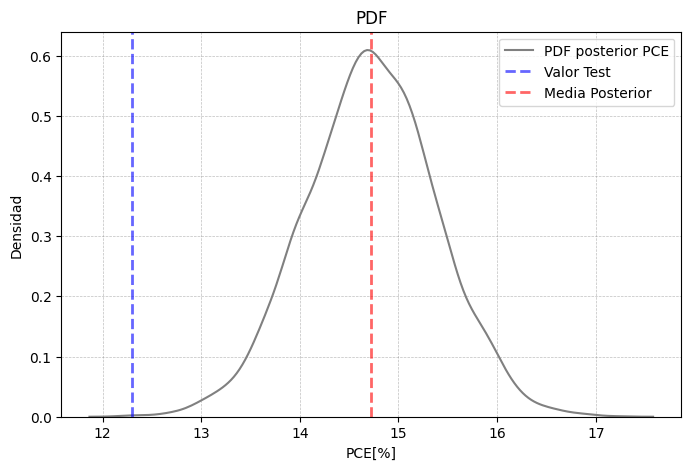

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': -0.6931471805599453}


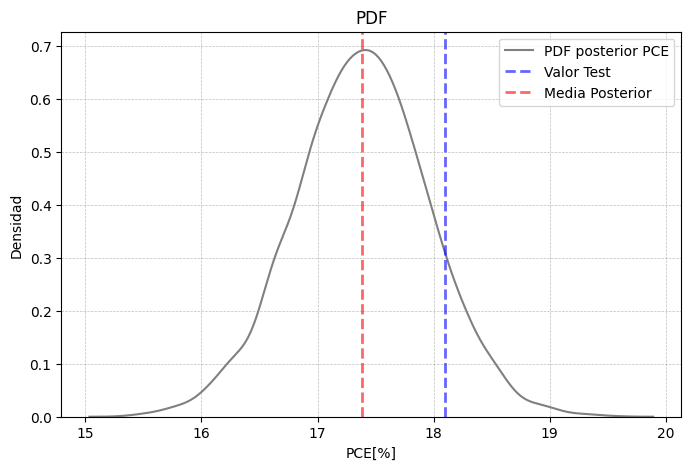

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': -0.6931471805599453}


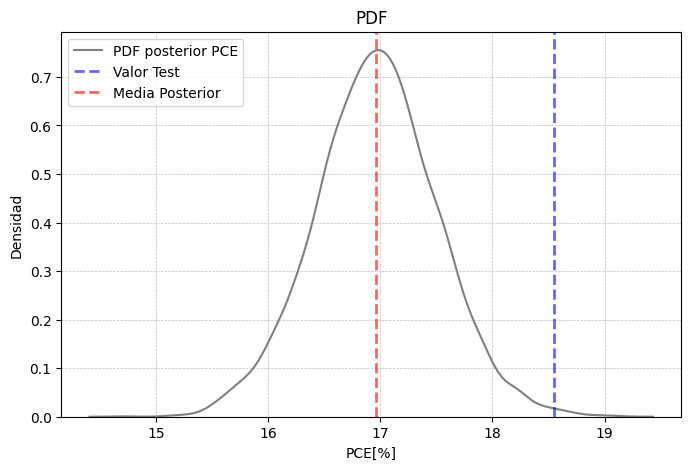

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': -1.2039728043259361}


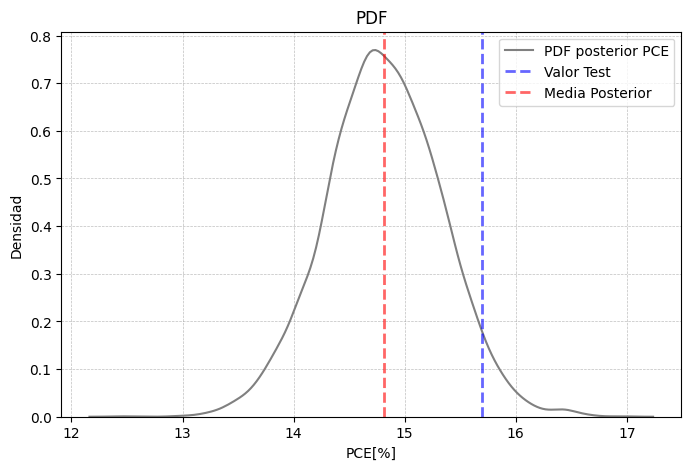

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


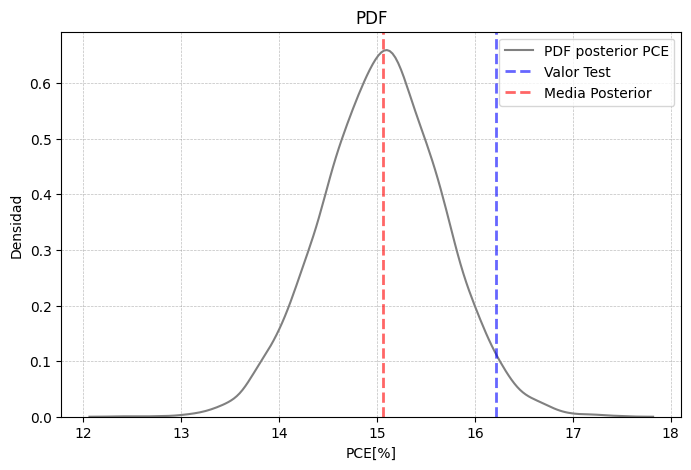

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


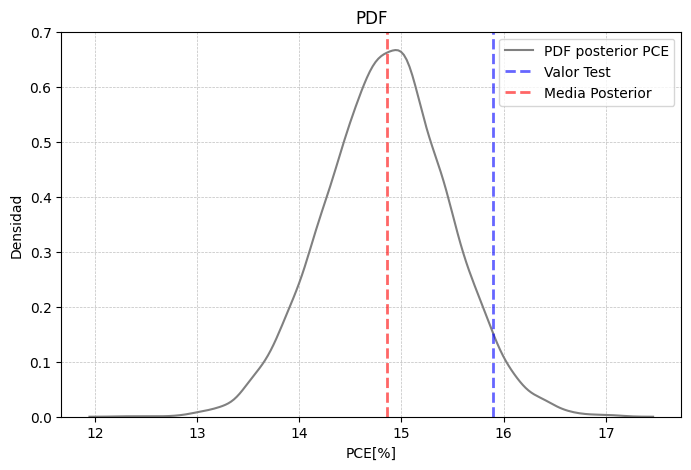

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': -1.0498221244986778}


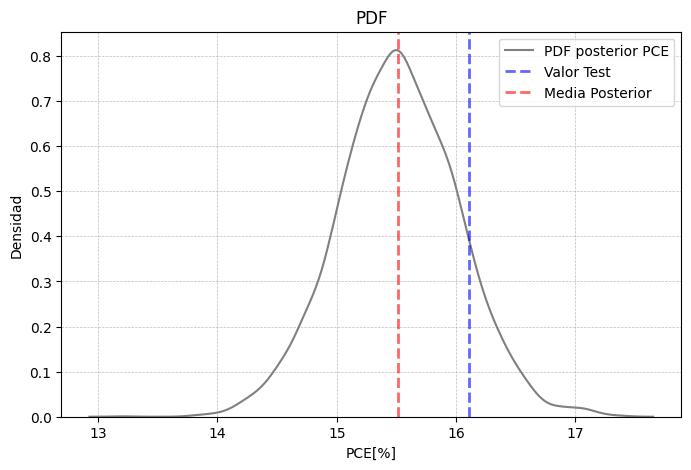

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': -0.8915981192837836}


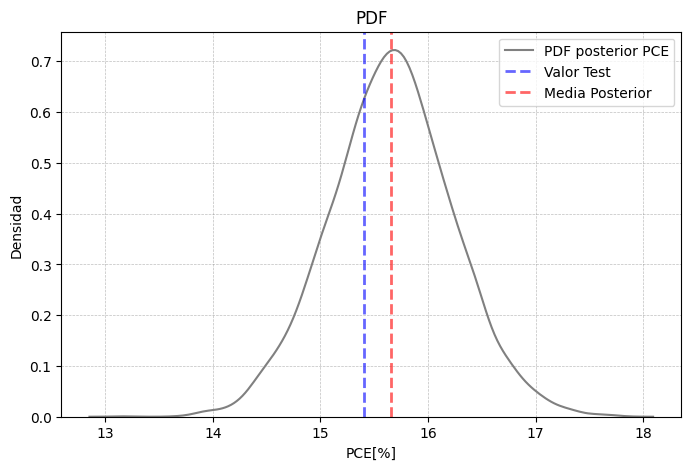

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


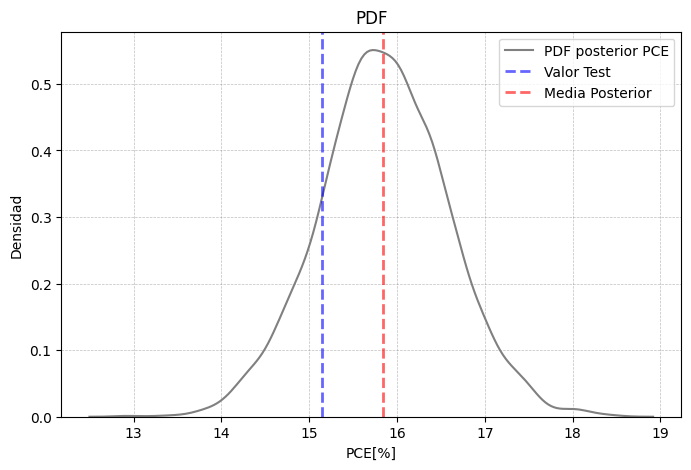

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


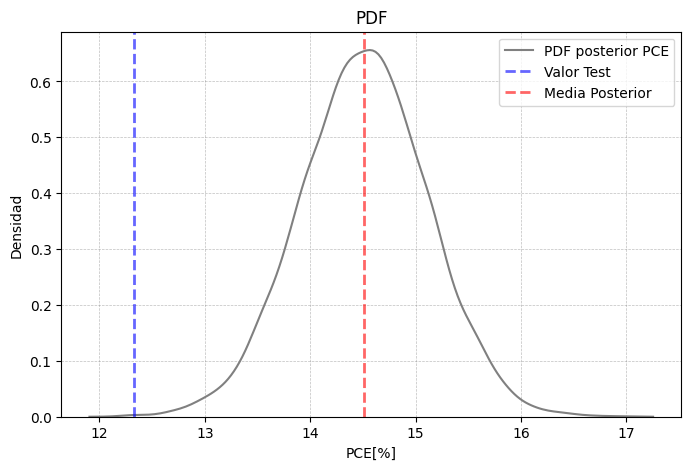

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': -1.2039728043259361}


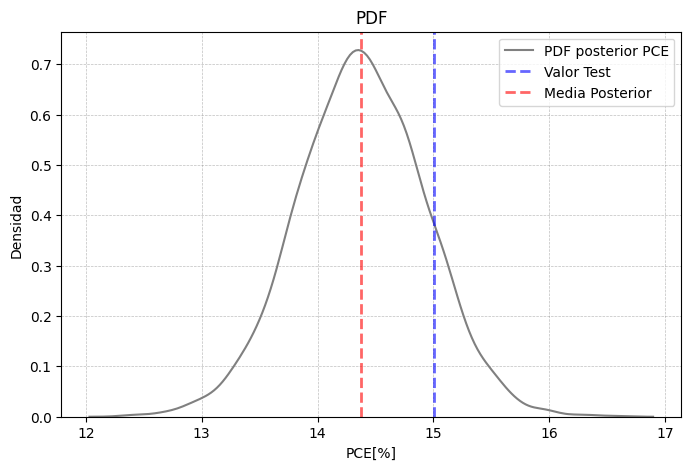

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': -0.5978370007556204}


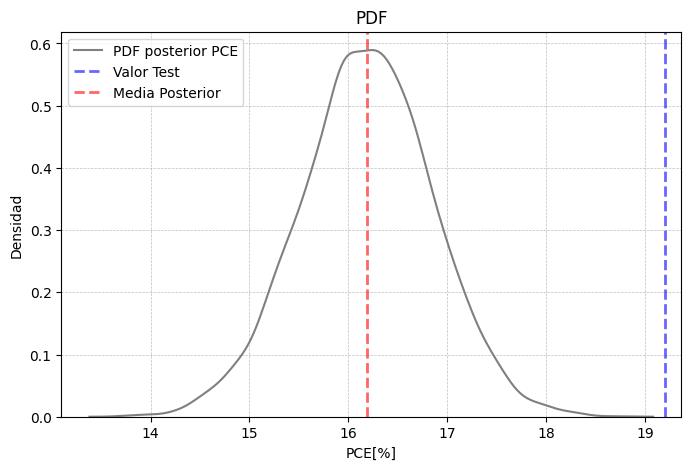

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': -1.2378743560016174}


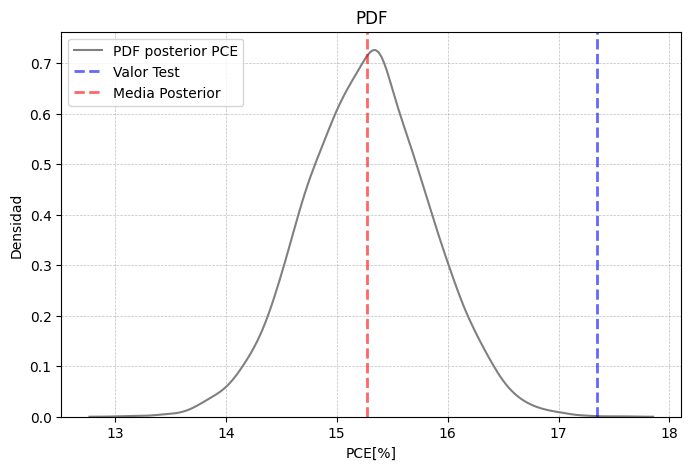

Voc
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': 0.4}


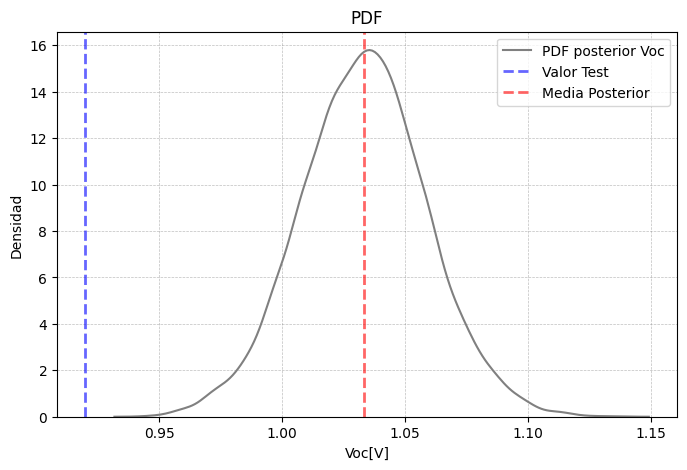

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': 0.5}


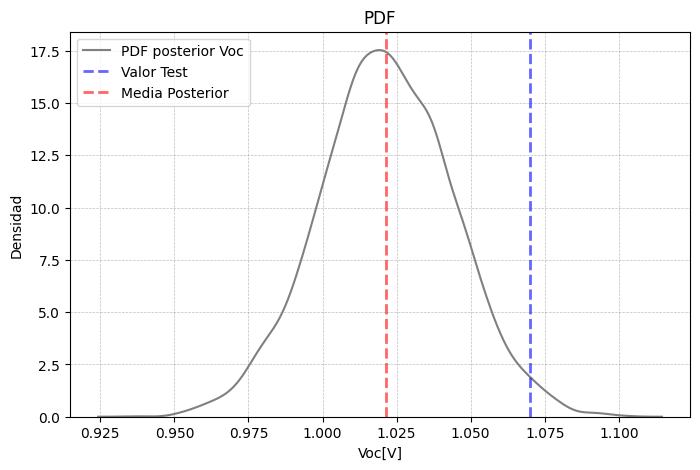

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': 0.5}


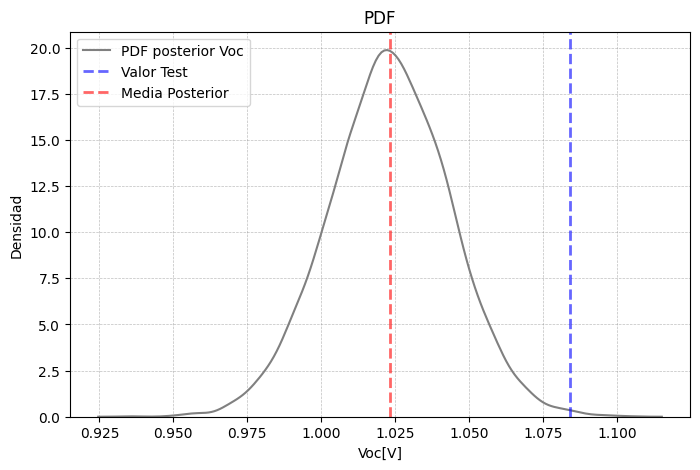

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': 0.3}


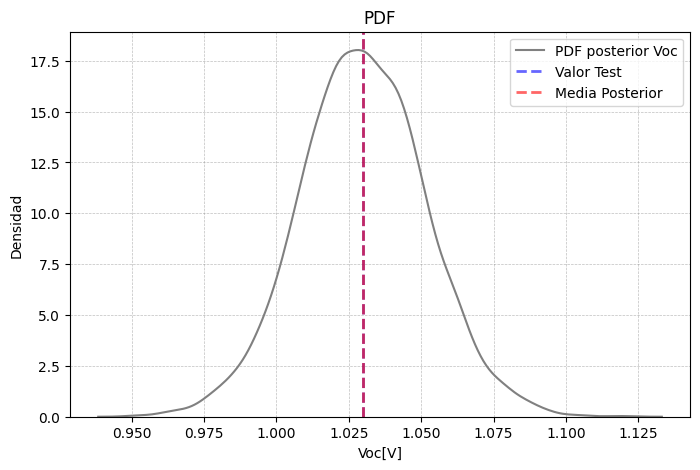

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


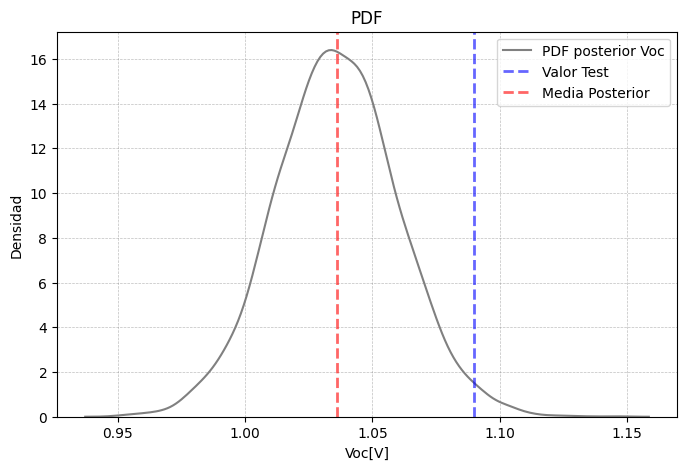

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


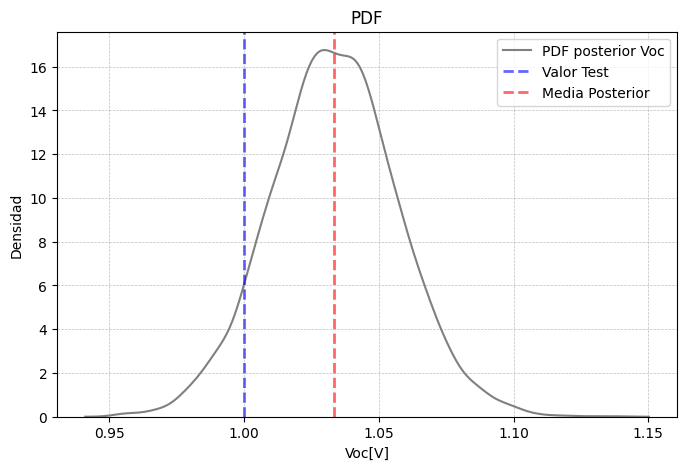

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': 0.35}


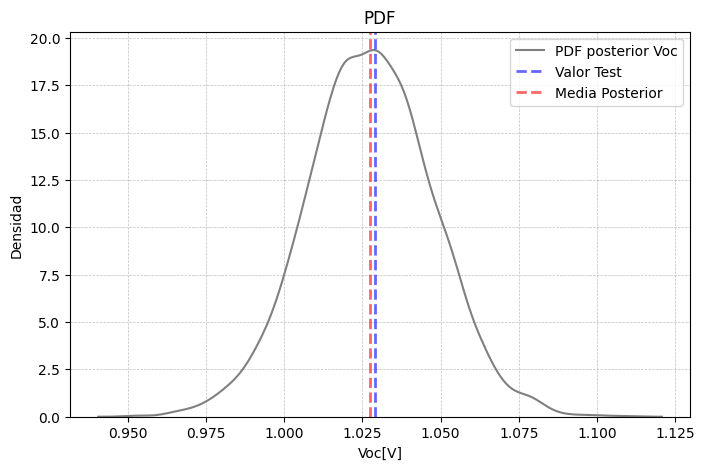

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': 0.41}


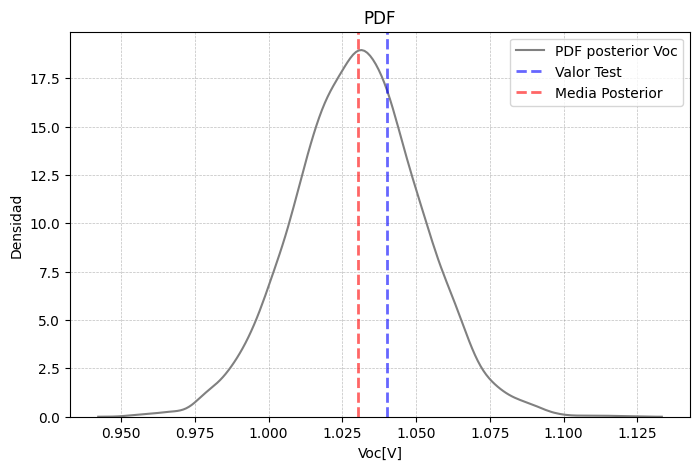

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': 0.35}


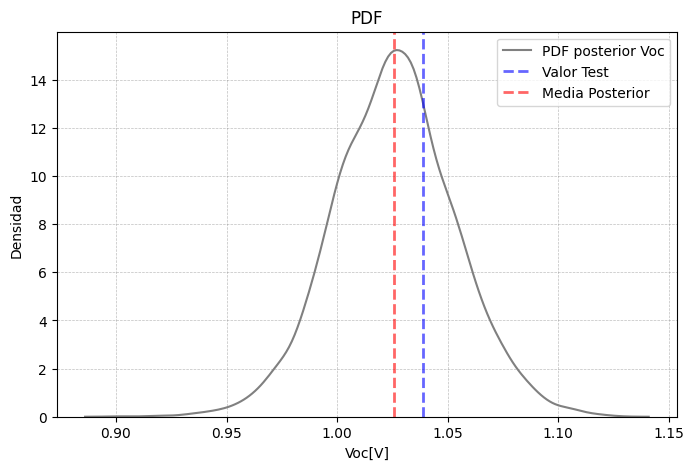

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': 0.35}


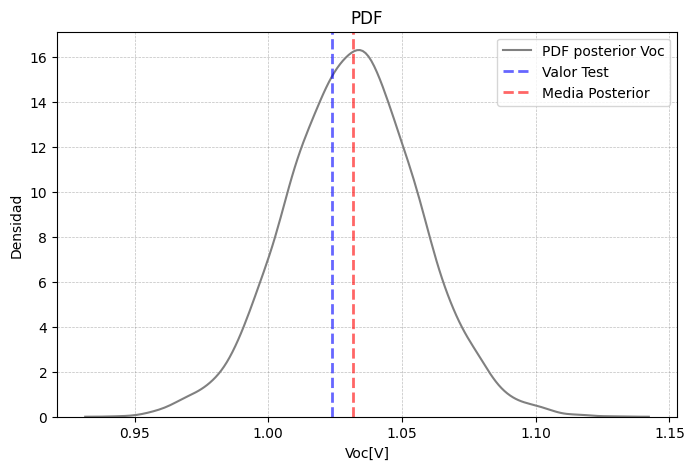

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': 0.3}


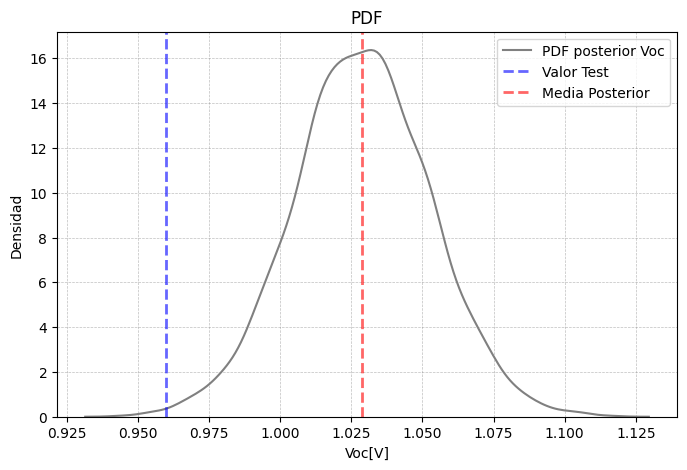

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': 0.55}


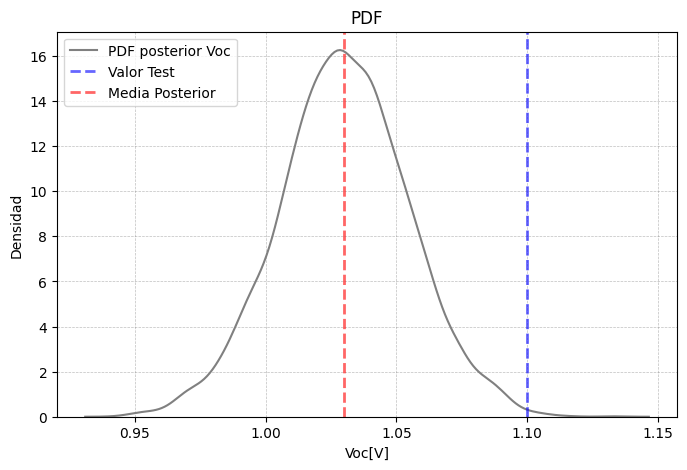

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': 0.29}


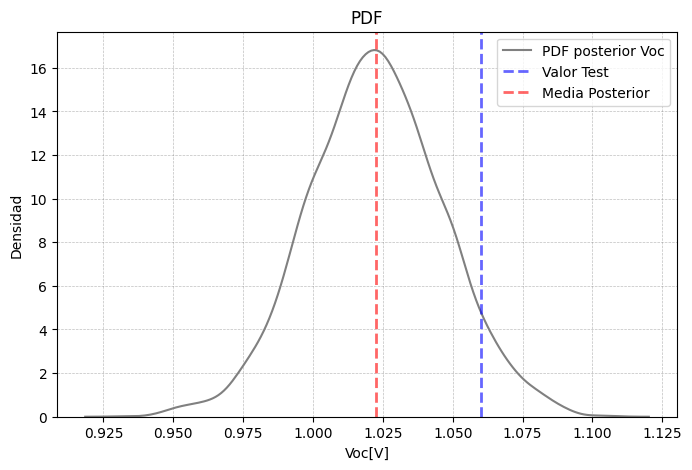

Jsc
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': -0.916290731874155}


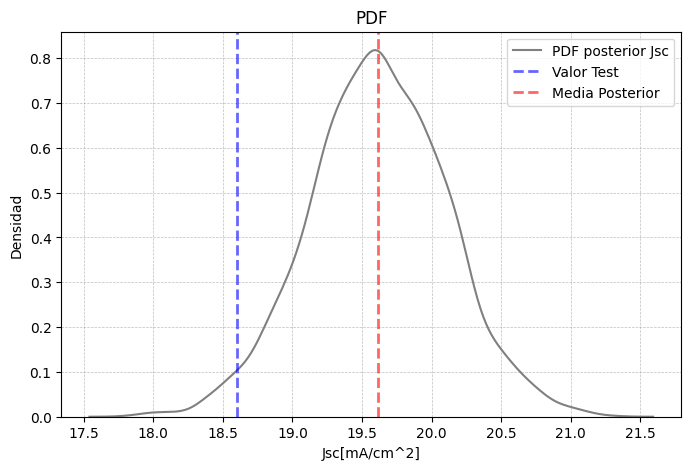

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': -0.6931471805599453}


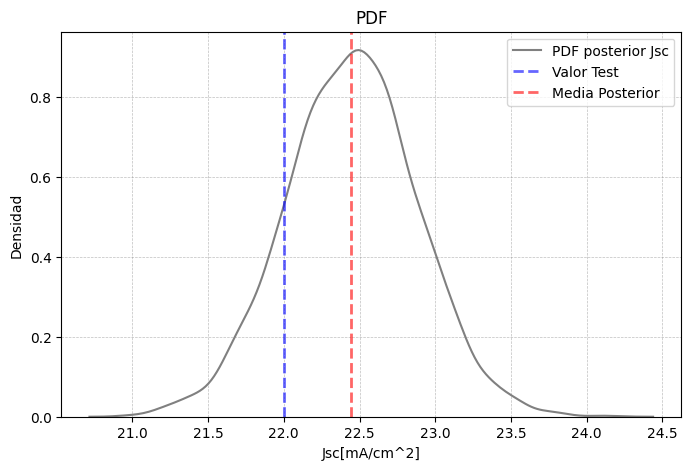

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': -0.6931471805599453}


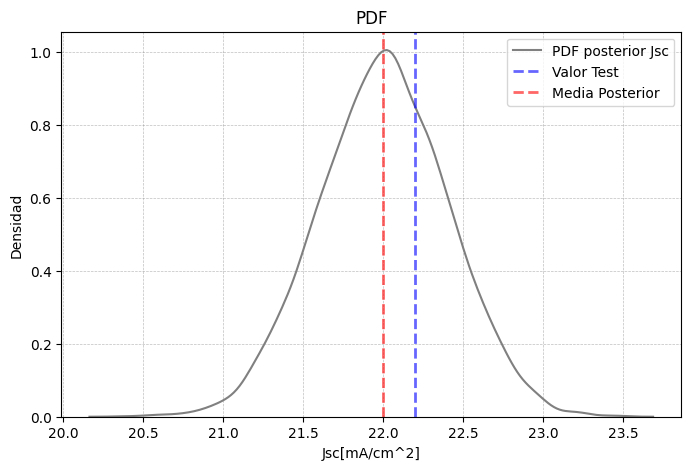

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': -1.2039728043259361}


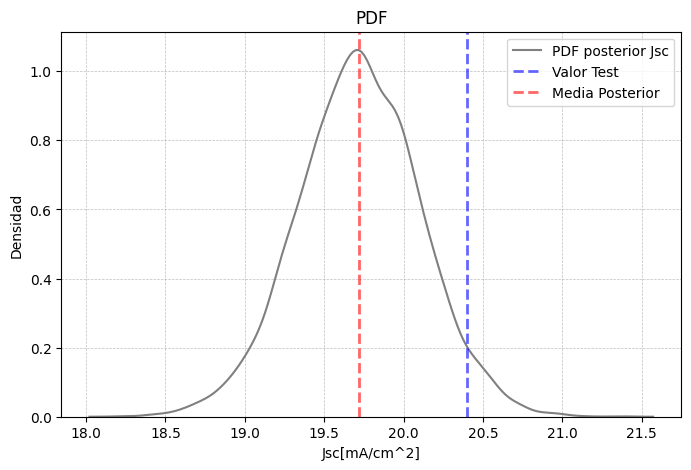

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


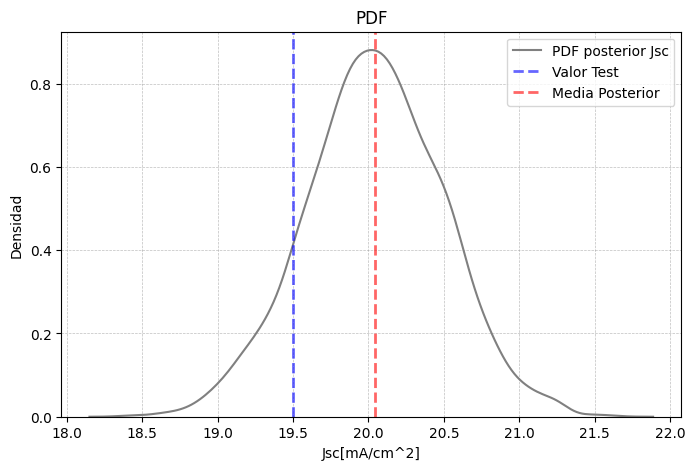

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': -1.0498221244986778}


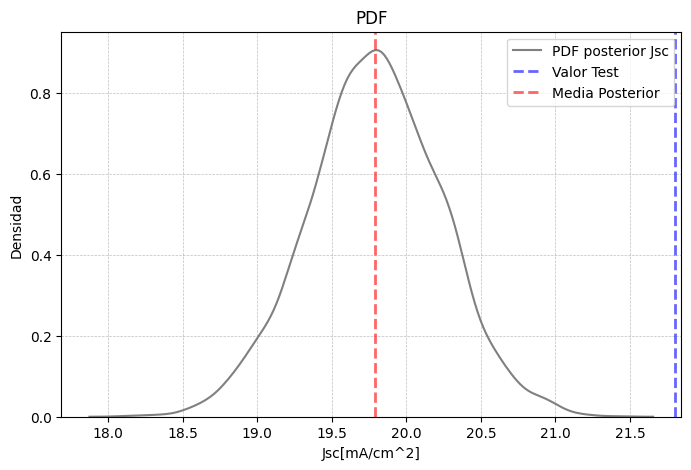

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': -1.0498221244986778}


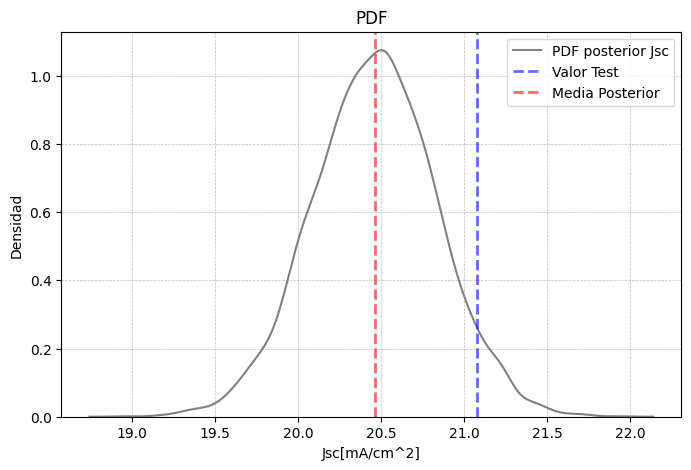

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': -0.8915981192837836}


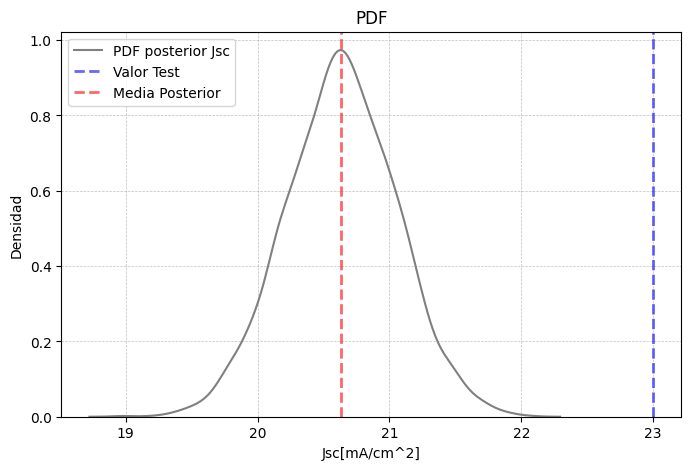

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


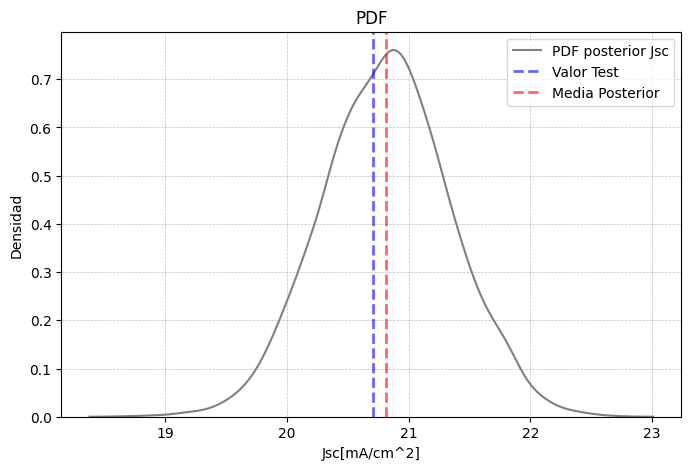

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': -1.0498221244986778}


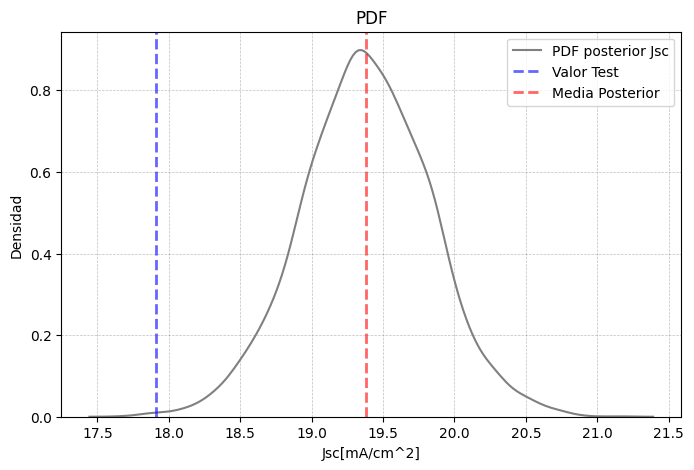

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': -1.2039728043259361}


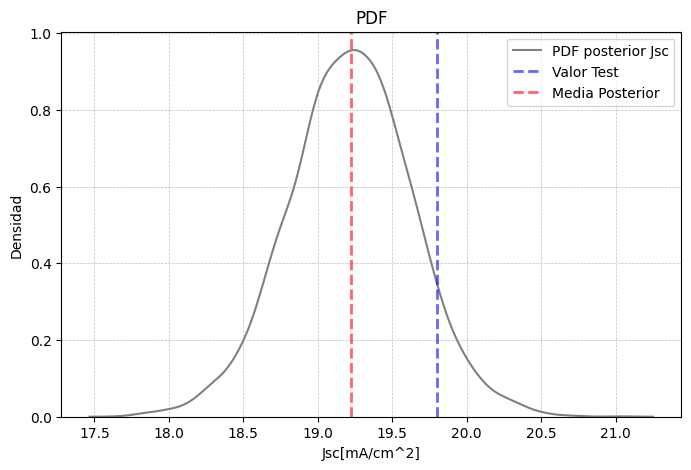

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': -0.5978370007556204}


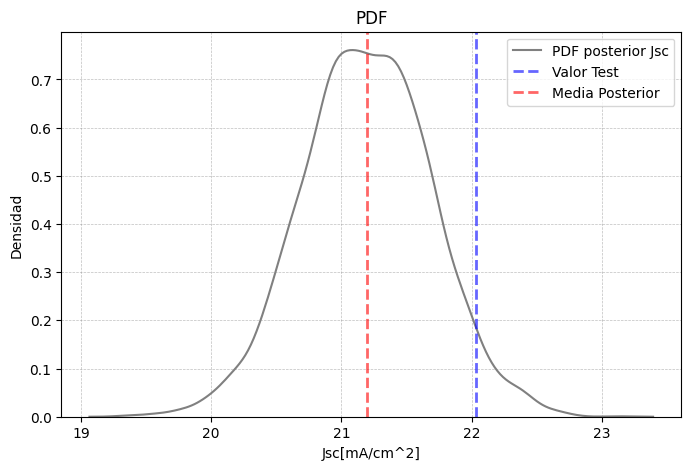

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': -1.2378743560016174}


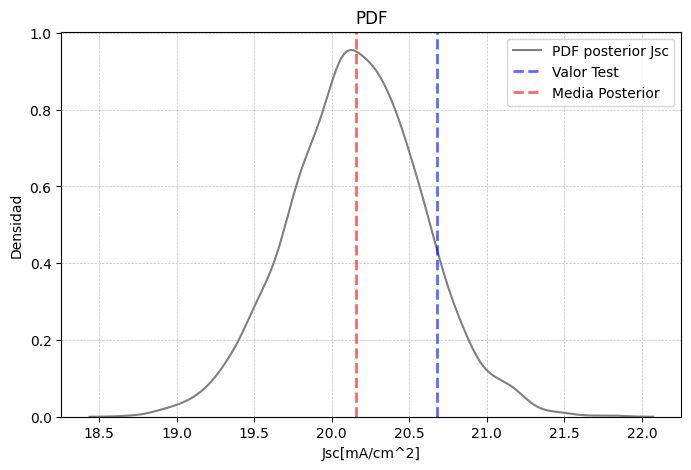

FF
2-fold
predicciones = 0
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.301, 'Thickness': 0.4}


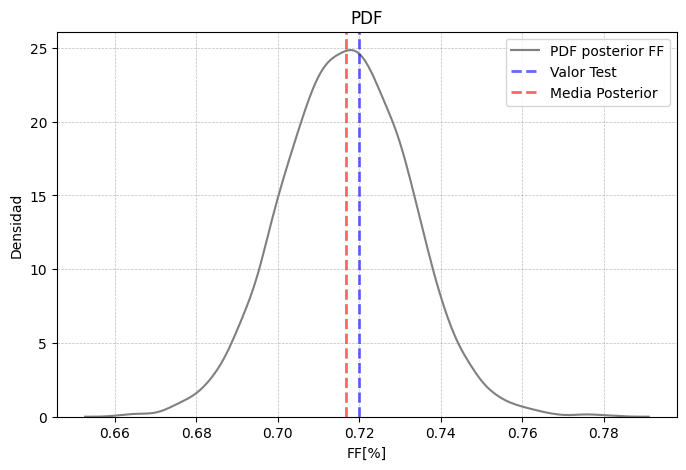

predicciones = 1
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.3, 'Grain_size': 1.154, 'Thickness': 0.5}


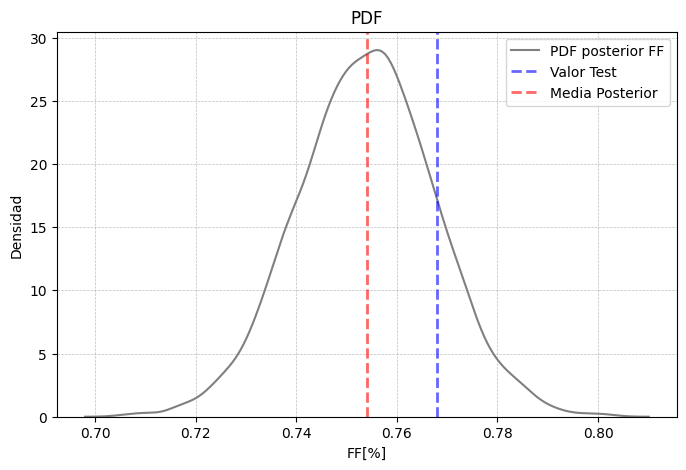

predicciones = 2
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.8, 'Thickness': 0.5}


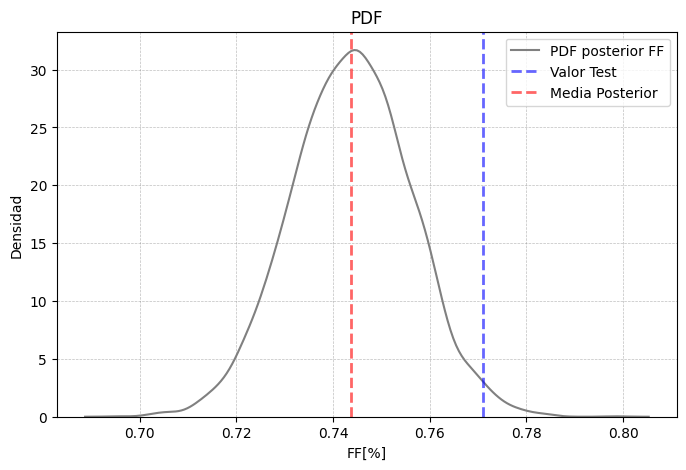

predicciones = 3
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.55, 'Thickness': 0.3}


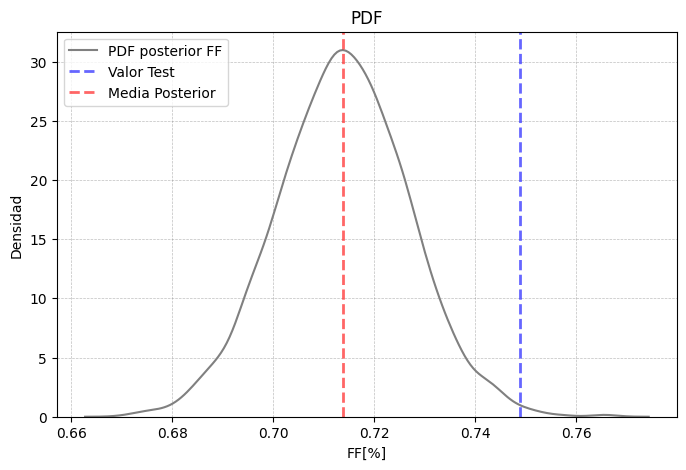

predicciones = 4
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.15, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


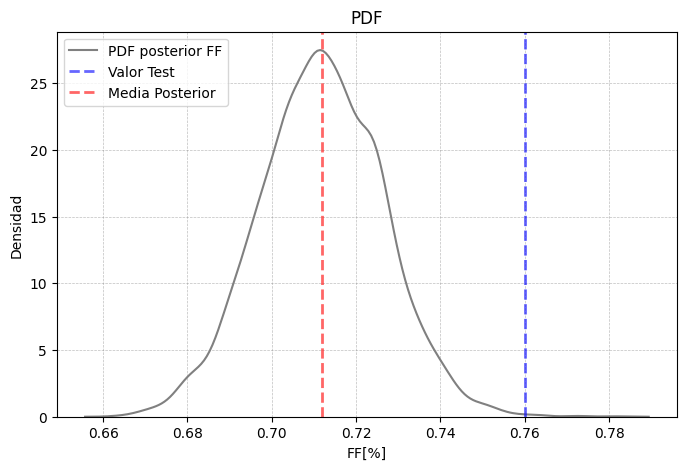

predicciones = 5
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.3, 'Thickness': 0.35}


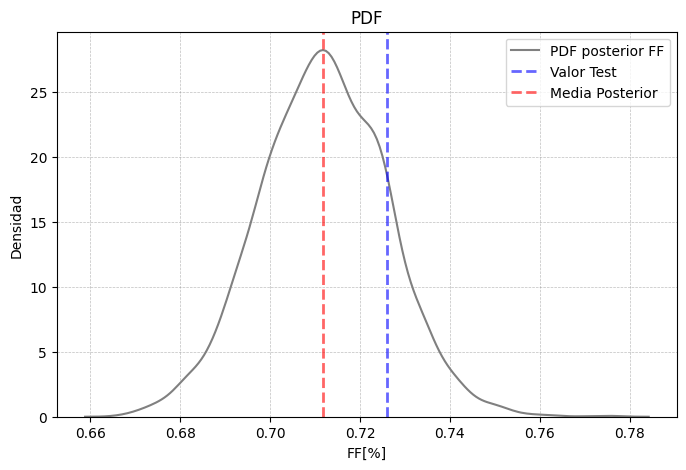

predicciones = 6
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.654, 'Thickness': 0.35}


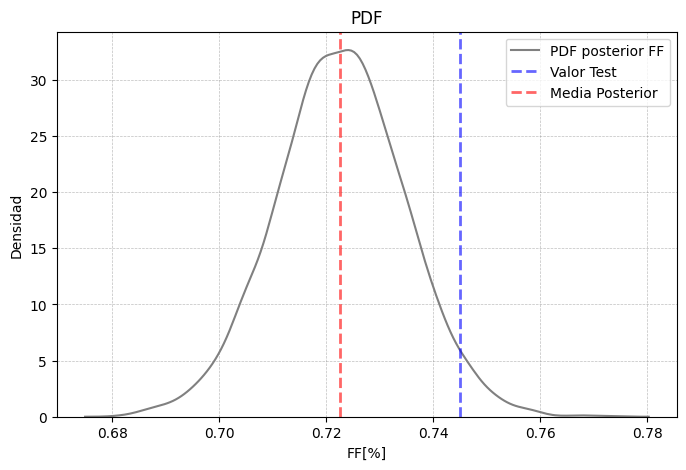

predicciones = 7
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.2, 'Grain_size': 0.45, 'Thickness': 0.41}


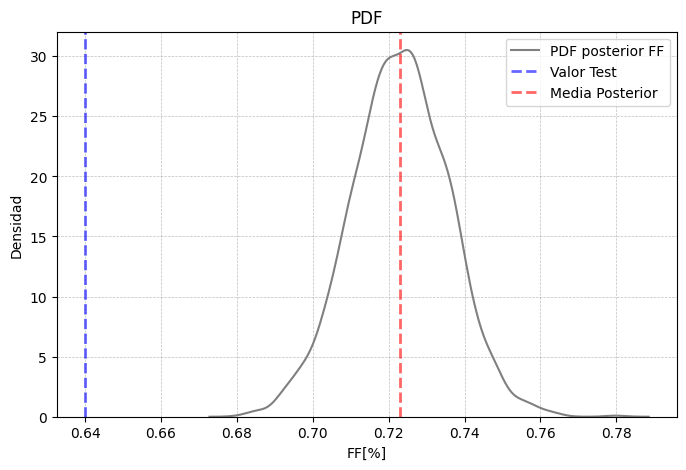

predicciones = 8
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.0, 'Grain_size': 0.425, 'Thickness': 0.35}


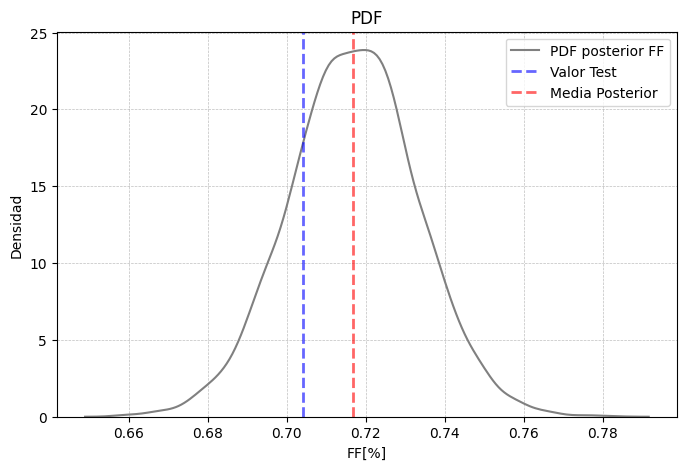

predicciones = 9
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.425, 'Thickness': 0.35}


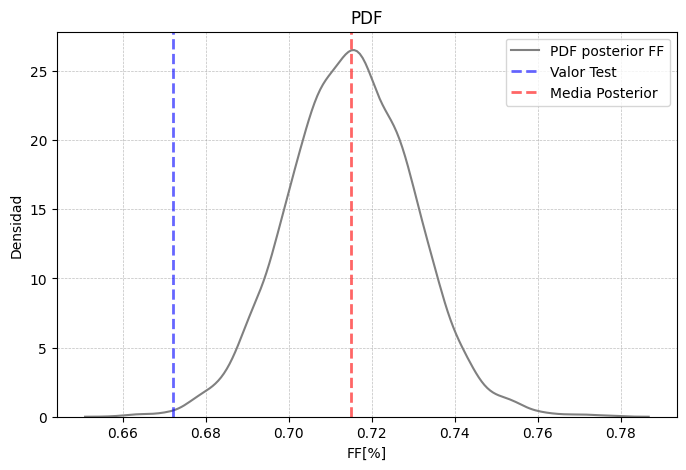

predicciones = 10
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.2, 'DeltaL': 0.3, 'Grain_size': 0.628, 'Thickness': 0.3}


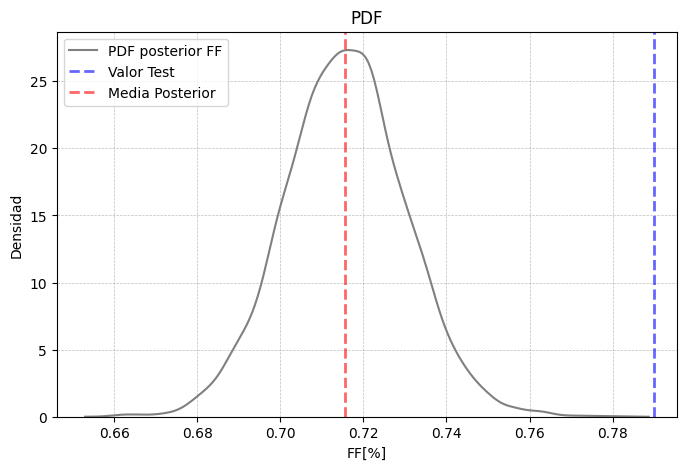

predicciones = 11
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.32, 'Grain_size': 0.5, 'Thickness': 0.55}


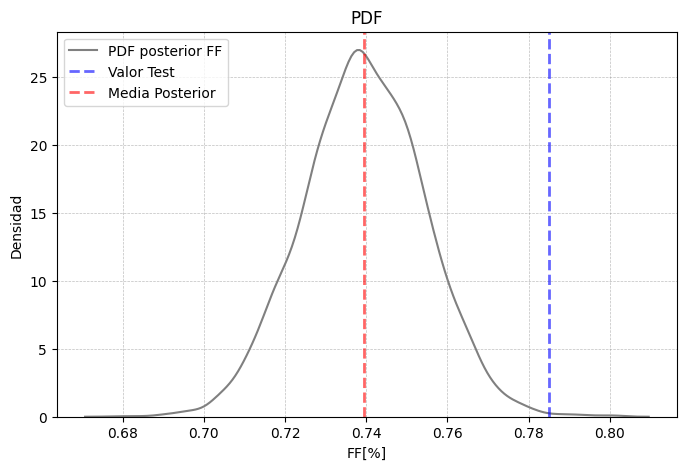

predicciones = 12
{'A': 1.0, 'B': 1.1559591794226542, 'X': 1.0, 'Band_gap': 1.5, 'DeltaH': 0.18, 'DeltaL': 0.3, 'Grain_size': 1.097, 'Thickness': 0.29}


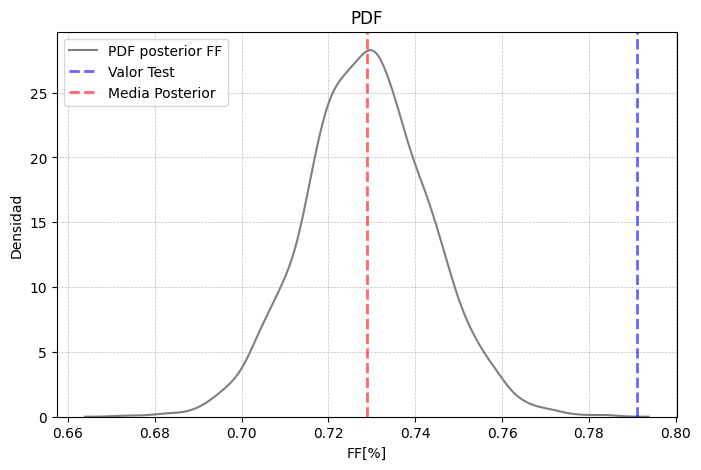

In [ ]:
# PDF de las predicciones (ejemplo)
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
unidades = {"Band_gap": "eV", "DeltaH": "eV", "DeltaL": "eV", "Grain_size": "mm", "Thickness": "mm", "PCE": "%", "Voc": "V", "Jsc": "mA/cm^2", "FF": "%"}
for datos in data[data.columns[8:]]:
  print(datos)
  for i in range(2,3):
    predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    test = (data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    x_mean = data_train[f'data_train_{datos}'][f'train_fold_{i}']['x_mean']
    x_std = data_train[f'data_train_{datos}'][f'train_fold_{i}']['x_std']
    x_test = data_test[f'data_test_{datos}'][f'test_fold_{i}']['x_test']
    x_test = (x_test*x_std) + x_mean
    print(f'{i}-fold')
    #print(x_test)
    for j in range(0,len(predicciones)):
      print(f"predicciones = {j}")
      x_test_temporal = {}
      for k in range(len(data.columns[:8])):
        x_test_temporal[data.columns[k]] = x_test[j][k]
      print(x_test_temporal)
      plt.figure(figsize=(8, 5))
      posterior_predictive = sns.kdeplot(predicciones[j], label = f'PDF posterior {datos}', color = "gray")
      plt.axvline(x=test[j], color='b', linestyle='--', linewidth=2, label='Valor Test', alpha = 0.6)
      # Calcular la media de la distribución de densidad posterior
      media_posterior = predicciones[j].mean()
      # Agregar línea vertical para la media de la distribución posterior
      plt.axvline(x=media_posterior, color='r', linestyle='--', linewidth=2, label='Media Posterior', alpha = 0.6)
      plt.xlabel(f"{datos}[{unidades[datos]}]")
      plt.ylabel("Densidad")
      plt.title("PDF")
      plt.legend()
      plt.grid(True, **grid_style)
      plt.show()

## Graficos de intervalo de credibilidad del 90%

PCE
Intervalo de confianza al 0.90: (15.31, 22.56)
min = [11.511052441068273], max = [25.53779643134366]
Valor porcentual HDI frente a la PDF =  51.70575936585453
Intervalo de confianza al 0.90: (13.93, 17.48)
min = [11.511052441068273, 12.231635309289937], max = [25.53779643134366, 19.575349304645247]
Valor porcentual HDI frente a la PDF =  48.35175085506812
Intervalo de confianza al 0.90: (7.43, 19.48)
min = [11.511052441068273, 12.231635309289937, -0.9779613783173282], max = [25.53779643134366, 19.575349304645247, 23.689156569397245]
Valor porcentual HDI frente a la PDF =  48.82665218671489
Intervalo de confianza al 0.90: (15.40, 20.87)
min = [11.511052441068273, 12.231635309289937, -0.9779613783173282, 11.06546239608365], max = [25.53779643134366, 19.575349304645247, 23.689156569397245, 24.043104483278157]
Valor porcentual HDI frente a la PDF =  42.14117603796815
Intervalo de confianza al 0.90: (9.11, 34.96)
min = [11.511052441068273, 12.231635309289937, -0.9779613783173282, 11.065

<Figure size 800x500 with 0 Axes>

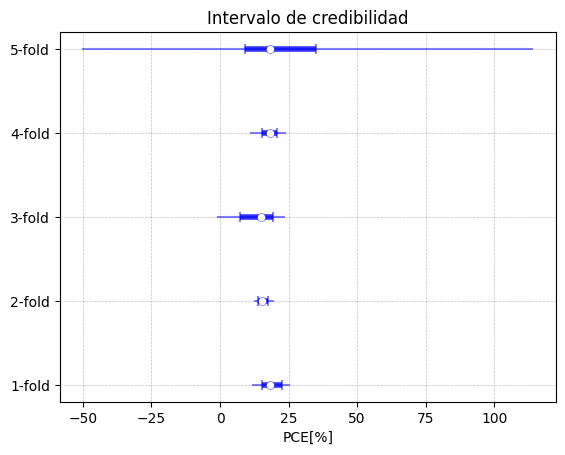

Voc
Intervalo de confianza al 0.90: (0.99, 1.27)
min = [0.7196367922673059], max = [1.4517399721722524]
Valor porcentual HDI frente a la PDF =  38.50848476176155
Intervalo de confianza al 0.90: (0.99, 1.07)
min = [0.7196367922673059, 0.901109531072255], max = [1.4517399721722524, 1.1452048433349007]
Valor porcentual HDI frente a la PDF =  32.18218590484489
Intervalo de confianza al 0.90: (0.92, 1.13)
min = [0.7196367922673059, 0.901109531072255, 0.6282037578512716], max = [1.4517399721722524, 1.1452048433349007, 1.2852466856219038]
Valor porcentual HDI frente a la PDF =  30.651101147972632
Intervalo de confianza al 0.90: (0.97, 1.14)
min = [0.7196367922673059, 0.901109531072255, 0.6282037578512716, 0.8520180593956928], max = [1.4517399721722524, 1.1452048433349007, 1.2852466856219038, 1.3065134475476827]
Valor porcentual HDI frente a la PDF =  36.61397408096093
Intervalo de confianza al 0.90: (0.91, 1.42)
min = [0.7196367922673059, 0.901109531072255, 0.6282037578512716, 0.8520180593956

<Figure size 800x500 with 0 Axes>

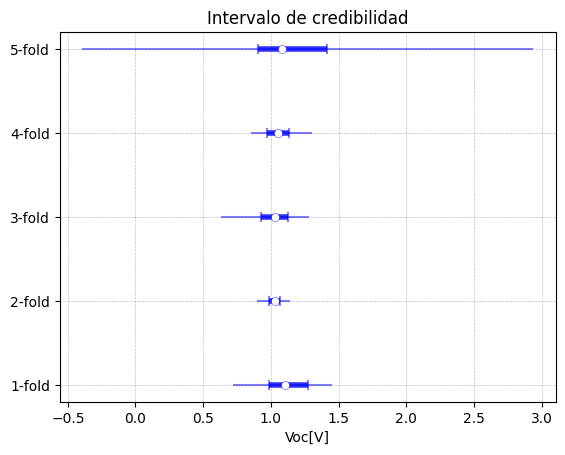

Jsc
Intervalo de confianza al 0.90: (19.54, 26.41)
min = [16.63366840536445], max = [28.767139085557247]
Valor porcentual HDI frente a la PDF =  56.57650158993553
Intervalo de confianza al 0.90: (18.99, 22.45)
min = [16.63366840536445, 17.691604321027647], max = [28.767139085557247, 24.20157536228398]
Valor porcentual HDI frente a la PDF =  53.18414596721469
Intervalo de confianza al 0.90: (14.56, 23.02)
min = [16.63366840536445, 17.691604321027647, 10.072853567316667], max = [28.767139085557247, 24.20157536228398, 25.787876204645965]
Valor porcentual HDI frente a la PDF =  53.87388789459558
Intervalo de confianza al 0.90: (20.36, 25.92)
min = [16.63366840536445, 17.691604321027647, 10.072853567316667, 16.8618277670093], max = [28.767139085557247, 24.20157536228398, 25.787876204645965, 29.041722861542038]
Valor porcentual HDI frente a la PDF =  45.64703650731063
Intervalo de confianza al 0.90: (13.75, 71.67)
min = [16.63366840536445, 17.691604321027647, 10.072853567316667, 16.861827767

<Figure size 800x500 with 0 Axes>

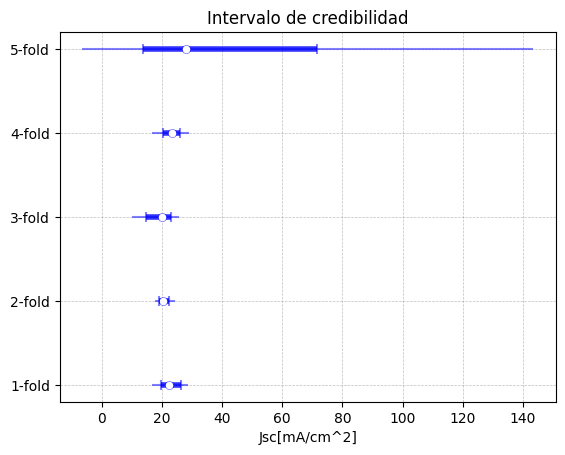

FF
Intervalo de confianza al 0.90: (0.70, 0.82)
min = [0.5545889945457025], max = [0.962582522937546]
Valor porcentual HDI frente a la PDF =  29.17170237052606
Intervalo de confianza al 0.90: (0.69, 0.76)
min = [0.5545889945457025, 0.6578781954898629], max = [0.962582522937546, 0.8025859947778962]
Valor porcentual HDI frente a la PDF =  44.03739259461951
Intervalo de confianza al 0.90: (0.63, 0.81)
min = [0.5545889945457025, 0.6578781954898629, 0.543739714035343], max = [0.962582522937546, 0.8025859947778962, 0.9609584933121844]
Valor porcentual HDI frente a la PDF =  42.04877809670784
Intervalo de confianza al 0.90: (0.70, 0.76)
min = [0.5545889945457025, 0.6578781954898629, 0.543739714035343, 0.6495629922297337], max = [0.962582522937546, 0.8025859947778962, 0.9609584933121844, 0.8167479856204979]
Valor porcentual HDI frente a la PDF =  40.40938735807906
Intervalo de confianza al 0.90: (0.46, 0.94)
min = [0.5545889945457025, 0.6578781954898629, 0.543739714035343, 0.6495629922297337, 

<Figure size 800x500 with 0 Axes>

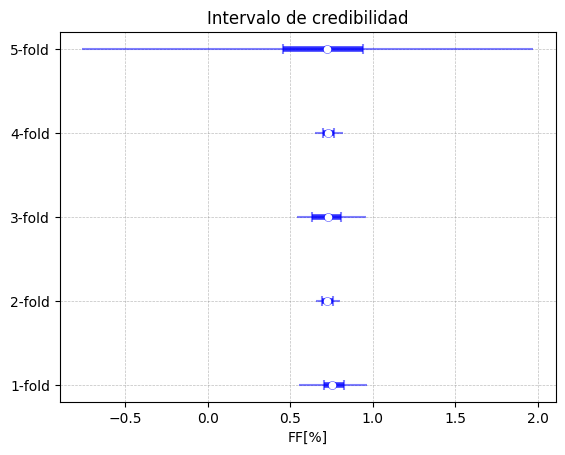

In [ ]:
alpha = 0.1
fold = ["1-fold", "2-fold", "3-fold", "4-fold", "5-fold"]
for datos in data[data.columns[8:]]:
  print(datos)
  ci_low = []
  ci_upper = []
  mean = []
  min = []
  max = []
  for i in range(1,6):
    lower_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], alpha/2 * 100)
    upper_bound = np.percentile(prediccion[f"prediccion_{datos}"][f"fold_{i}"], (1 - alpha/2) * 100)
    min_ = np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    max_ = np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"])
    min.append(np.min(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    max.append(np.max(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    ci_low.append(lower_bound)
    ci_upper.append(upper_bound)
    mean.append(np.mean(prediccion[f"prediccion_{datos}"][f"fold_{i}"]))
    print(f"Intervalo de confianza al {1-alpha:.2f}: ({lower_bound:.2f}, {upper_bound:.2f})")
    print(f"min = {min}, max = {max}")
    porcentaje_hdi = (upper_bound-lower_bound)/(max_-min_)*100
    print('Valor porcentual HDI frente a la PDF = ', porcentaje_hdi)
  # Crear un arreglo de posiciones para las barras horizontales
  positions = np.arange(len(fold))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()
  # Dibujar las barras horizontales principales
  ax.hlines(positions, min, max, colors='b', alpha=0.5, linewidth=1.5)
  # Dibujar las barras horizontales secundarias
  ax.hlines(positions, ci_low, ci_upper, colors='b', alpha=0.8, linewidth=4)

  # Dibujar los puntos de estimación puntual
  ax.scatter(mean, positions, color='blue', marker='o', s = 30, zorder=10, alpha = 0.5)
  ax.scatter(mean, positions, color='white', marker='o', s = 20, zorder=10, alpha = 1)
  ax.scatter(ci_low, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  ax.scatter(ci_upper, positions, color='blue', marker='|', s = 50, zorder=10, alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_yticks(positions)
  ax.set_yticklabels(fold)
  ax.set_xlabel(f'{datos}[{unidades[datos]}]')
  #ax.set_ylabel('Parámetros')
  # Título del gráfico
  ax.set_title(f'Intervalo de credibilidad')
  # Mostrar el gráfico
  ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/HDI/'
  plt.grid(True, **grid_style)
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de relacion entre estimaciones y datos reales

PCE


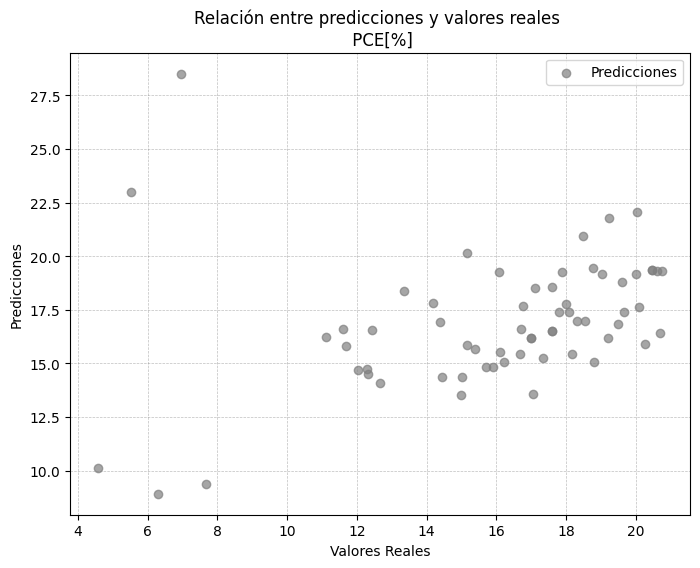

Voc


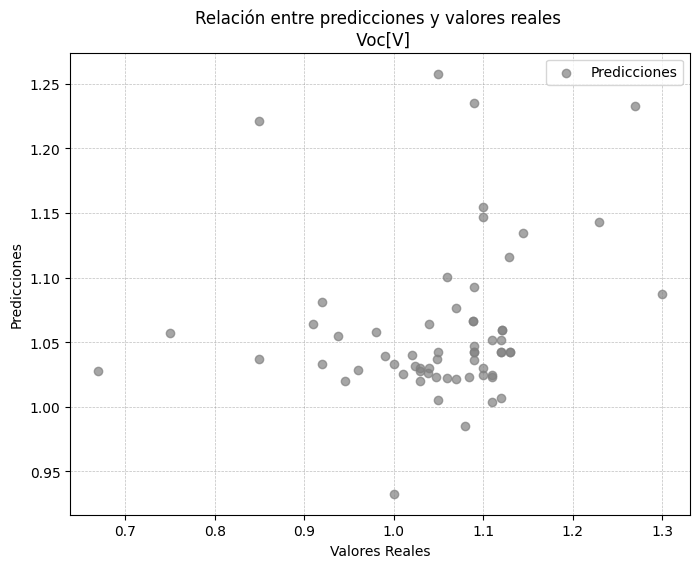

Jsc


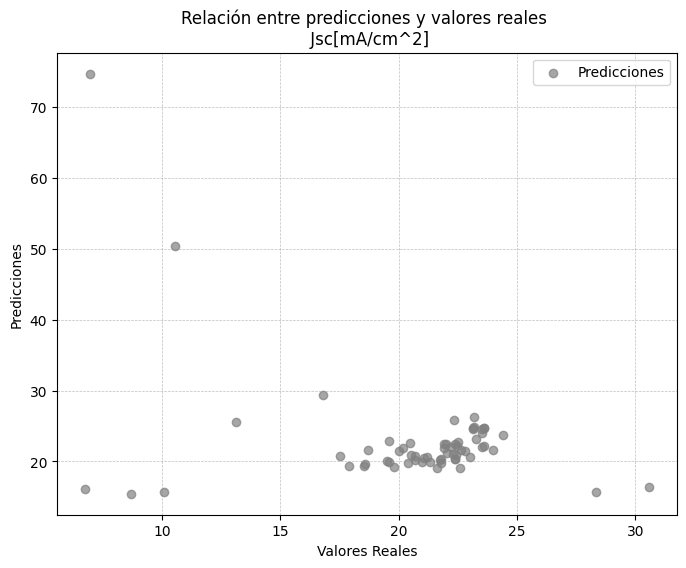

FF


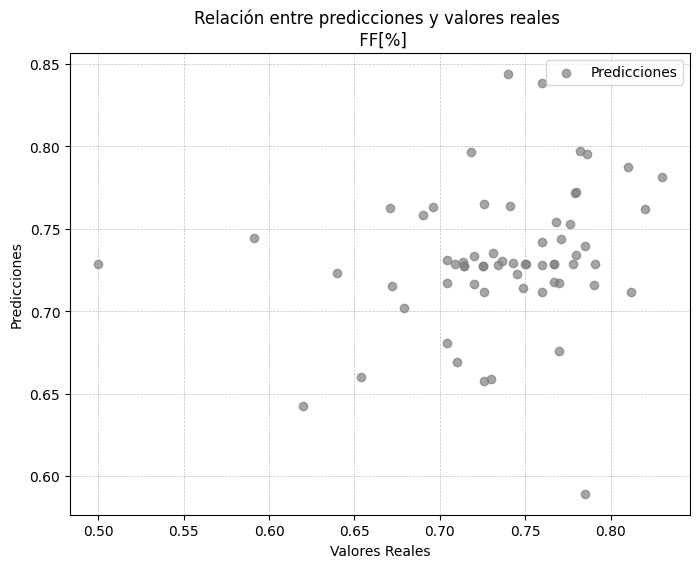

In [ ]:
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/CorrelacionPvR/'
for datos in data[data.columns[8:]]:
  print(datos)
  predicciones = []
  valor_real = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  valores_reales = np.concatenate(valor_real)
  plt.figure(figsize=(8, 6))
  plt.scatter(valores_reales, valores_predichos, label='Predicciones', color='gray', alpha = 0.7)
  plt.xlabel(f'Valores Reales')
  plt.ylabel('Predicciones')
  plt.title(f'Relación entre predicciones y valores reales \n {datos}[{unidades[datos]}]')
  plt.legend()
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  plt.show()

## Grafico de comparacion de estimaciones vs datos reales

PCE
[16.4133149  17.6404279  17.77837291 16.24504977 19.32023946 20.92210949
 20.15708126 16.50206943 16.50206943 16.19717922 16.19717922 22.07554792
 21.78499687]
[14.7195913  17.38127728 16.96607    14.81156856 15.0561277  14.85533976
 15.51493907 15.65788648 15.84475045 14.50921051 14.37786539 16.18794709
 15.2735285 ]
[16.92709824 13.53486633 18.39173127 15.4461915  19.29491466 16.84291407
  9.36421942 10.10899353  8.92415479 17.39875872 14.35838112 15.07669377
 16.58651362]
[16.57000616 15.83119252 19.34962177 19.34962177 19.19143565 19.19143565
 18.78701211 16.96710619 19.42871482 19.27052871 17.67484738 16.61323559]
[14.6938239  17.37994854 18.49908633 18.54827545 14.08738036 22.98725392
 15.9244212  15.45193512 17.79858764 13.56239584 19.28203558 28.51261456]


<Figure size 800x500 with 0 Axes>

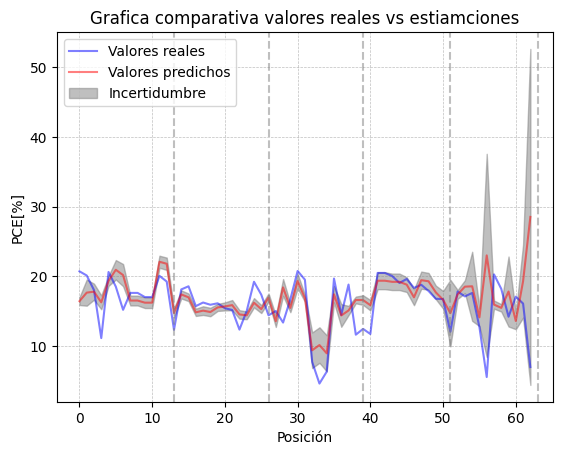

Voc
[1.02472964 1.01976641 1.08149808 1.01971213 1.13424434 1.23494227
 1.25776816 1.06673647 1.06673647 1.05969749 1.05969749 1.14694149
 1.15464326]
[1.03319361 1.02145797 1.02312272 1.02982888 1.03603372 1.03353691
 1.02743727 1.03023277 1.02584238 1.03165663 1.02875844 1.03001799
 1.02246174]
[1.03963968 1.04020456 1.05459381 1.02336104 1.1161942  1.02292854
 1.0426665  1.06427664 1.02562804 0.98531987 0.93280002 1.00673503
 1.0369191 ]
[1.03681679 1.00368573 1.04262221 1.04262221 1.04232547 1.04232547
 1.05146558 1.09259607 1.04277058 1.04247384 1.07660088 1.10059367]
[1.087485   1.02440441 1.00540264 1.05693488 1.06383504 1.22123482
 1.05183761 1.04679417 1.02785924 1.05823121 1.14284966 1.23306456]


<Figure size 800x500 with 0 Axes>

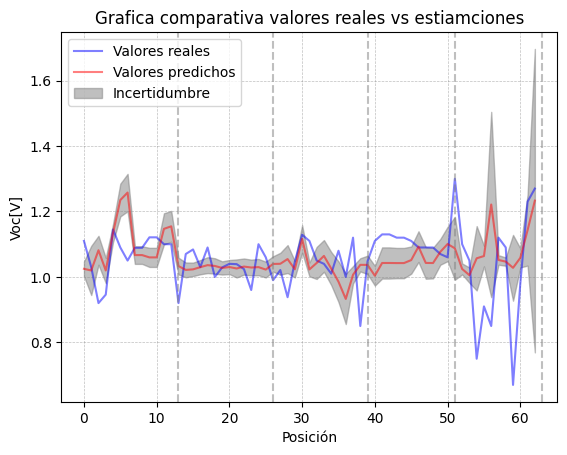

Jsc
[21.57649792 22.09571475 22.46209478 20.7384331  23.15401799 23.78045709
 22.66687653 20.31992964 20.31992964 19.94467924 19.94467924 26.31563567
 25.88538488]
[19.61706131 22.44707681 22.00186901 19.71963167 20.04114031 19.78967109
 20.46262619 20.63452068 20.81808335 19.38043383 19.22104726 21.19365701
 20.16034104]
[21.91469953 19.09493447 22.92482053 20.67362937 22.20212899 21.66116897
 15.66134103 16.13829176 15.45617975 22.20109506 19.33919414 20.36748227
 21.56805967]
[21.48030782 20.90088669 24.78087832 24.78087832 24.57887632 24.57887632
 24.002725   21.41004405 24.88187931 24.67987732 22.41830886 20.90591164]
[25.50678355 21.84311174 22.71182697 16.33630312 19.91437319 50.43632758
 21.06312164 20.27311019 15.68503339 19.03658269 29.35621966 74.67579017]


<Figure size 800x500 with 0 Axes>

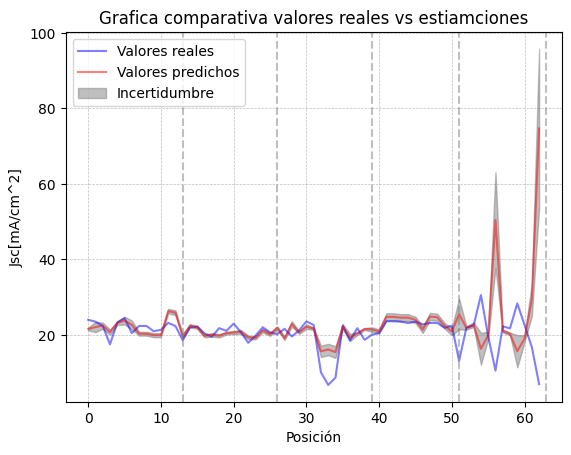

FF
[0.73436052 0.78131258 0.76186776 0.76280564 0.74220183 0.76349308
 0.75852601 0.72729743 0.72729743 0.72724048 0.72724048 0.79513038
 0.79713595]
[0.71677418 0.75397232 0.74376136 0.71390811 0.71183403 0.71182072
 0.72263976 0.72306886 0.71687491 0.71501074 0.71566171 0.73940018
 0.72889365]
[0.73326731 0.70216423 0.76513595 0.72842512 0.77177999 0.75285574
 0.65857163 0.66002209 0.65795545 0.7876726  0.77258226 0.71707107
 0.73561788]
[0.74444245 0.72843447 0.72893558 0.72893558 0.72829732 0.72829732
 0.72870584 0.73054418 0.72925472 0.72861645 0.72982927 0.73090164]
[0.68042358 0.76364055 0.79681353 0.83839911 0.66939801 0.64258487
 0.71191615 0.71761504 0.844111   0.67573011 0.72875848 0.58926061]


<Figure size 800x500 with 0 Axes>

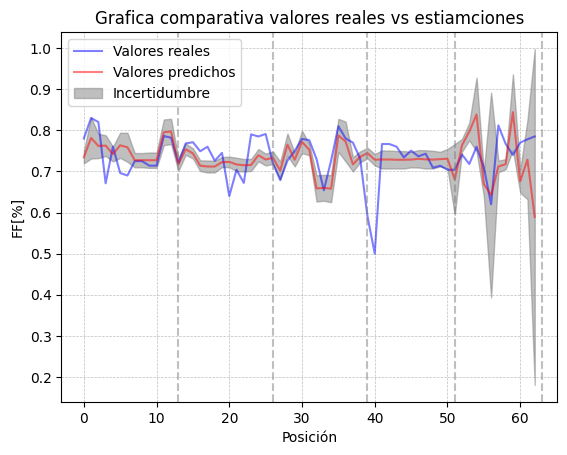

In [ ]:
# Especifica la ruta de la carpeta en Google Drive donde deseas guardar la imagen
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/Comportamiento_predicciones/'
for datos in data[data.columns[8:]]:
  print(datos)
  predicciones = []
  desviaciones_std = []
  valor_real = []
  posiciones = []
  for i in range(1,6):
    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    desviaciones_std.append(desviacion_std[f"desviacion_std_{datos}"][f"fold_{i}"])
    print(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
    posiciones.append(len(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"]))
    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
  valores_predichos = np.concatenate(predicciones)
  desviaciones_std = np.concatenate(desviaciones_std)
  valor_superior = np.array(valores_predichos) + np.array(desviaciones_std)
  valor_inferior = np.array(valores_predichos) - np.array(desviaciones_std)
  valores_reales = np.concatenate(valor_real)
  x = np.arange(len(valores_predichos))
  # Crear la figura y los ejes
  plt.figure(figsize=(8, 5))
  fig, ax = plt.subplots()

  # Graficar los valores en función de las posiciones con colores diferentes
  ax.plot(x, valores_reales, color='blue', linestyle='-', label='Valores reales', alpha = 0.5)
  ax.plot(x, valores_predichos, color='red', linestyle='-', label='Valores predichos', alpha = 0.5)
  ax.fill_between(x, valor_superior, valor_inferior, color='gray', alpha=0.5, label='Incertidumbre')
  nueva_posicion = 0
  for posicion in posiciones:
    nueva_posicion = posicion + nueva_posicion
    ax.axvline(x=nueva_posicion, color='gray', linestyle='--', alpha = 0.5)
  # Etiquetas de los ejes
  ax.set_xlabel('Posición')
  ax.set_ylabel(f'{datos}[{unidades[datos]}]')
  # Título de la gráfica
  ax.set_title(f'Grafica comparativa valores reales vs estiamciones')
  # Leyenda
  ax.legend()
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  # Mostrar la gráfica
  plt.show()

## Grafico de densidad conjunta de las predicciones vs los datos reales

In [ ]:
#for datos in data[data.columns[3:]]:
#  print(datos)
#  predicciones = []
#  valor_real = []
#  for i in range(1,6):
#    predicciones.append(prediccion_mean[f"prediccion_{datos}"][f"fold_{i}"])
#    valor_real.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
#  valores_predichos = np.concatenate(predicciones)
#  valores_reales = np.concatenate(valor_real)
#  # Crear un DataFrame con los datos
#  df_data = pd.DataFrame({'Valores Predichos': valores_predichos, 'Valores Reales': valores_reales})
#
#  # Crear el gráfico de densidad conjunta
#  sns.jointplot(data=df_data, x='Valores Predichos', y='Valores Reales', kind='kde')
#  #plt.title(f"Grafico de densidad conjunta para {datos}")
#  # Mostrar el gráfico
#  plt.show()
#

## Densidad posterior predictiva

PCE


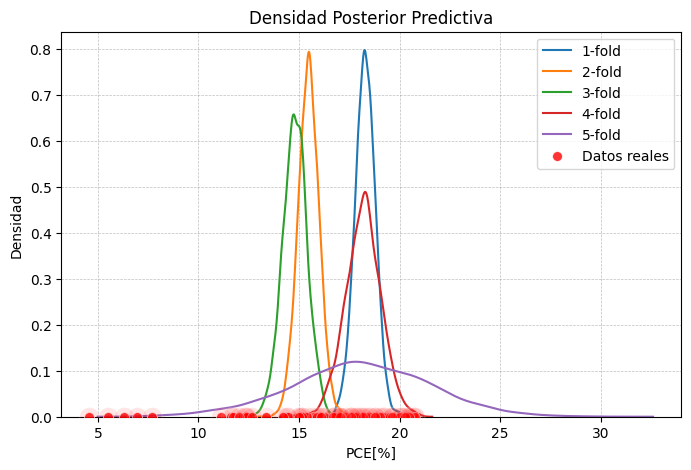

Voc


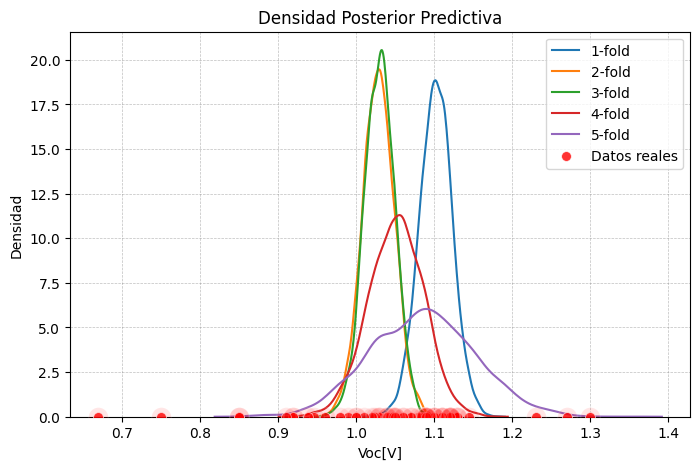

Jsc


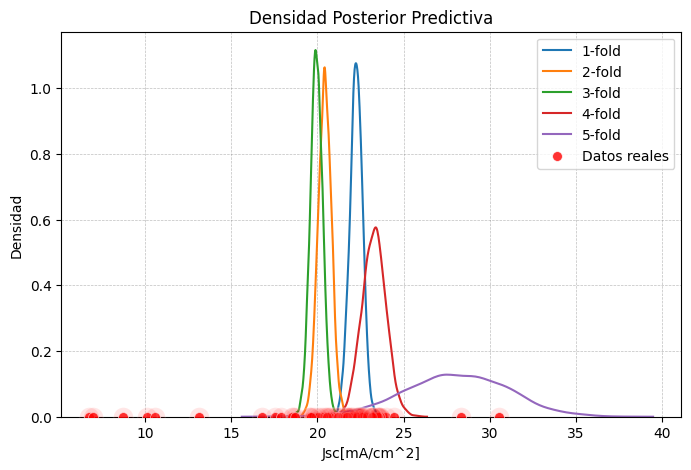

FF


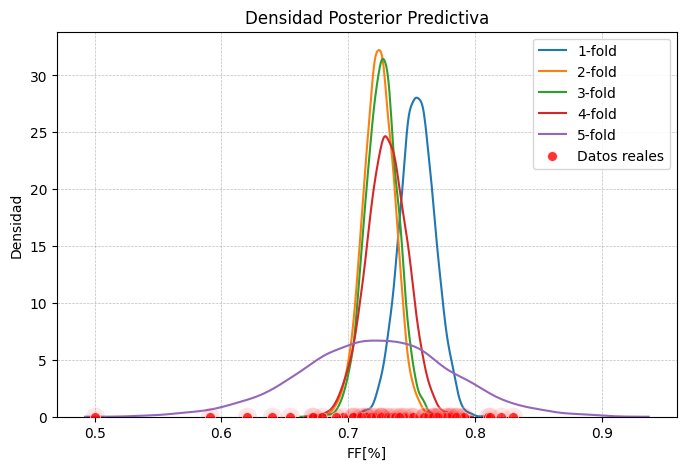

In [ ]:
# PDF de las predicciones (ejemplo)
ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/DPP/'
for datos in data[data.columns[8:]]:
  print(datos)
  densidad_predicciones = []
  test = []
  predicciones_ = []
  for i in range(1,6):
    pdf_predicciones = prediccion[f"prediccion_{datos}"][f"fold_{i}"]
    densidad_prediccion = np.mean([pdf_predicciones[j] for j in range(len(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test']))], axis=0)
    densidad_predicciones.append(densidad_prediccion)
    test.append(data_test[f'data_test_{datos}'][f'test_fold_{i}']['y_test'])
    predicciones_.append(pdf_predicciones)
  test = np.concatenate(test)
  densidad_predicciones = np.asarray(densidad_predicciones)
  #densidad_predicciones = np.mean([densidad_predicciones[j] for j in range(0,5)], axis = 0)

  # Crear el gráfico
  plt.figure(figsize=(8, 5))
  # Histograma de los datos de prueba
  for i in range(0,5):
    posterior_predictive = sns.kdeplot(densidad_predicciones[i], label = f'{i+1}-fold')
  sns.scatterplot(x=test, y=np.zeros_like(test), color='red', marker='o',s = 50, zorder=10, alpha = 0.8, label = "Datos reales")
  sns.scatterplot(x=test, y=np.zeros_like(test), color='r', marker='o',s = 200, alpha = 0.1, zorder=10)
  plt.xlabel(f"{datos}[{unidades[datos]}]")
  plt.ylabel('Densidad')
  plt.title(f'Densidad Posterior Predictiva')
  plt.grid(True, **grid_style)
  # Guarda la figura en un archivo (por ejemplo, en formato PNG) en la carpeta de Drive
  plt.savefig(ruta + f'{datos}.png')
  plt.show()


##Grafico del trazado para cada variable y cada modelo generado

In [ ]:
#for datos in data[data.columns[8:9]]:
#  print(datos)
#  for i in range(1,6):
#    idata = az.convert_to_inference_data(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'])
#    print(datos, f'fold#{i}')
#    az.plot_trace(idata, var_names = ['A', "B", "X", "Band_gap"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["DeltaH", "DeltaL",'Grain_size', "Thickness"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    az.plot_trace(idata, var_names = ["PCE", "Voc", "Jsc", "FF"], kind = "trace", figsize=(10,10))
#    plt.tight_layout()
#    plt.show()

<Figure size 800x500 with 0 Axes>

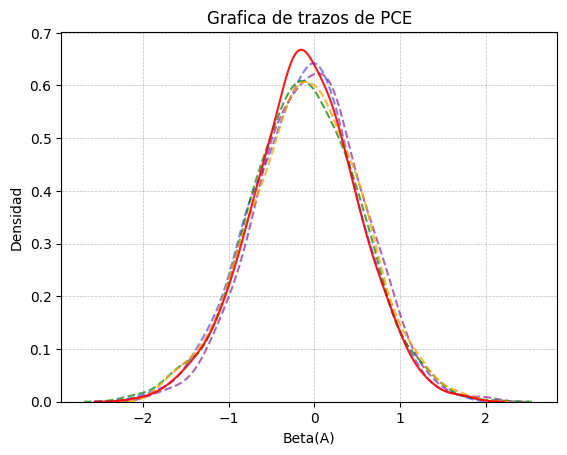

<Figure size 800x500 with 0 Axes>

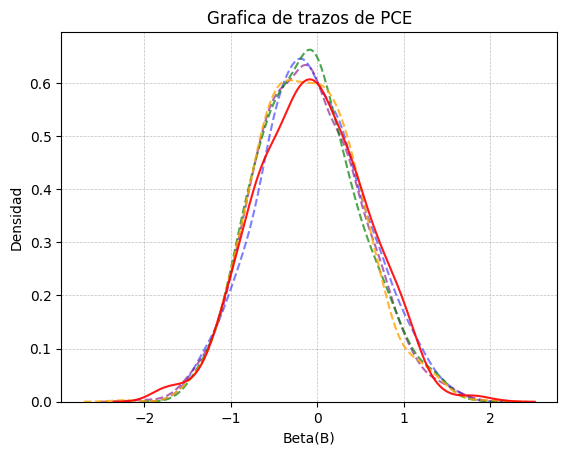

<Figure size 800x500 with 0 Axes>

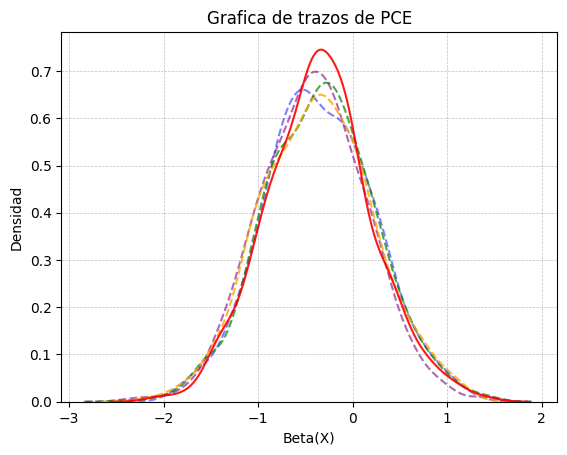

<Figure size 800x500 with 0 Axes>

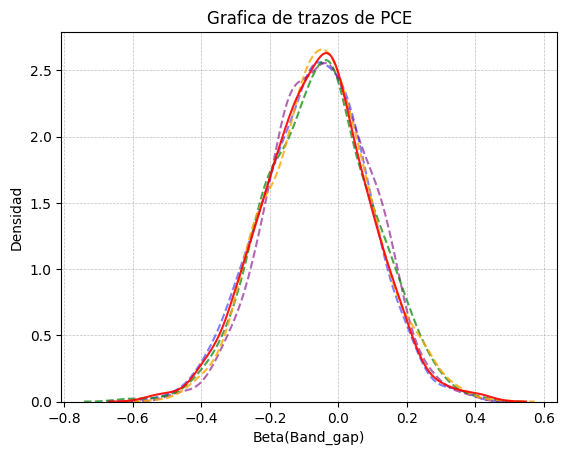

<Figure size 800x500 with 0 Axes>

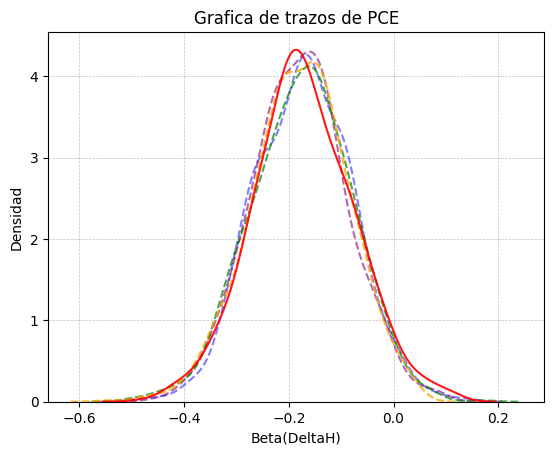

<Figure size 800x500 with 0 Axes>

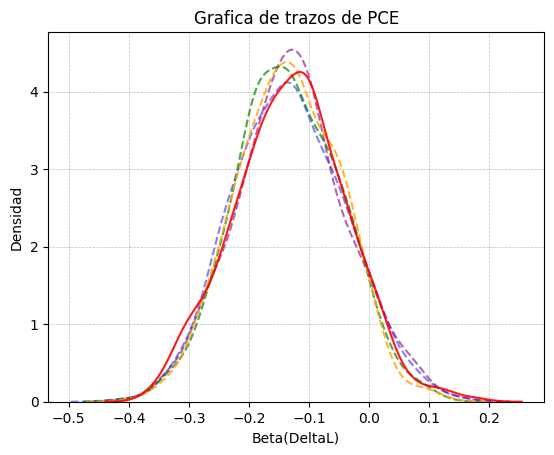

<Figure size 800x500 with 0 Axes>

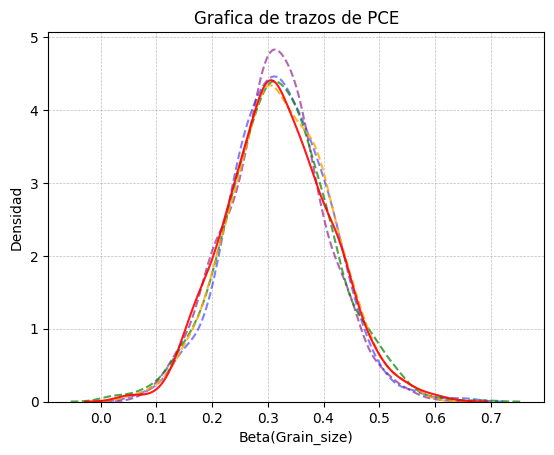

<Figure size 800x500 with 0 Axes>

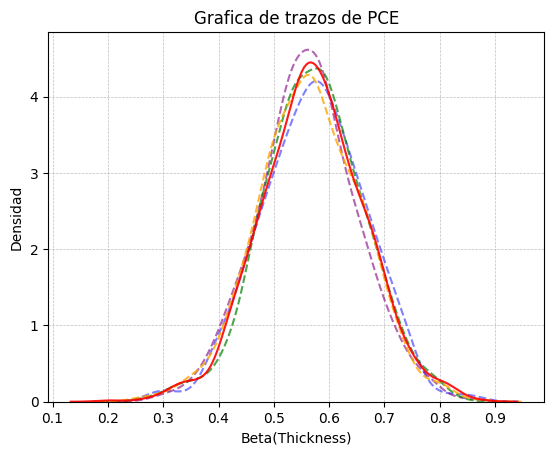

In [ ]:
#names = ['A','B','X', 'Band_gap', 'DeltaH', 'DeltaL', 'Grain_size', 'Thickness', "PCE", "Voc", "Jsc", "FF"]
grid_style = {'color': 'gray', 'linestyle': '--', 'linewidth': 0.5, 'alpha': 0.5}
estilo_linea = ["--", "--", "--", "--", "-"]
transparencia = [0.5, 0.6, 0.7, 0.8, 0.9]
colores = ['b', 'purple', 'g', 'orange', 'r']
for datos in data[data.columns[8:9]]:
  for i in range(5,6):
    for name in names:
      plt.figure(figsize=(8, 5))
      fig, ax = plt.subplots()
      for j in range (0,5):
        sns.kdeplot(trazados_cargados[f'trace_{datos}'][f'trace_fold{i}']['posterior'][name][j], linestyle=estilo_linea[j], alpha = transparencia[j], color = colores[j])
        plt.title(f"Grafica de trazos de {datos}")
        plt.ylabel("Densidad")
        plt.xlabel(f"Beta({name})")
        plt.grid(True, **grid_style)
        ruta = '/content/drive/My Drive/Deep Learning/TG/Imagenes/Regression/SAMPLEO/'
        plt.savefig(ruta + f'trazos_{datos}_{name}.png')
      plt.show()